In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
import time
from qutip.ui.progressbar import BaseProgressBar

## Generate 

In [2]:
### DEFINE SYSTEM OPERATORS
N = 2 #for spin 1/2
N_spin = 2

qeye_list = [qeye(N) for i in range(N_spin)] #identity matrices
sigmax_list = [] #list of pauli operators for each spin
sigmay_list = []
sigmaz_list = []

for i in range(N_spin): #setup list of annihilation operators
    '''
    E.g. For three oscillators, this builds the list 
    [tensor(a,qeye,qeye), tensor(qeye,a,qeye), tensor(qeye,qeye,a)]
    '''
    
    # Pauli-X operator for the i-th spin
    temp1 = qeye_list.copy()
    temp1[i] = sigmax() 
    sigmax_list.append(tensor(temp1))
    
    # Pauli-Y operator for the i-th spin
    temp2 = qeye_list.copy()
    temp2[i] = sigmay() 
    sigmay_list.append(tensor(temp2))
    
    # Pauli-Z operator for the i-th spin
    temp3 = qeye_list.copy()
    temp3[i] = sigmaz() 
    sigmaz_list.append(tensor(temp3))

In [3]:
def spin_chain_H(N_spin, J, h, sigmax_list, sigmay_list, sigmaz_list):
    """
    Constructs the Hamiltonian for an XY spin chain with a transverse field.

    Parameters:
    N_spin (int): Number of spins in the chain.
    J (float): Interaction strength between neighboring spins.
    h (float): Strength of the transverse field.
    sigmax_list (list): List of Pauli-X operators for each spin.
    sigmay_list (list): List of Pauli-Y operators for each spin.
    sigmaz_list (list): List of Pauli-Z operators for each spin.

    Returns:
    Qobj: The Hamiltonian of the spin chain as a Qobj instance.
    """
    H_int = 0
    for j in range(N_spin-1):
        H_int += J/2 * (sigmax_list[j]*sigmax_list[j+1] + sigmay_list[j]*sigmay_list[j+1])
    
    H_field = 0
    for j in range(N_spin):
        H_field += h * sigmaz_list[j]
        
    return H_int + H_field

In [4]:
def stochastic_solve(H,gamma,times):

    ntraj=50
    L = np.sqrt(gamma) * sigmaz_list[2] 
    
    rho0 = tensor([fock(N, 0) for i in range(N_spin)])
    
    c_ops = []
    sc_ops = [L]
    e_ops = [sigmaz_list[0], sigmaz_list[7]]
    
    opt = Options(store_states = False)
    result = smesolve(H, rho0, times, c_ops, sc_ops,
                  e_ops, ntraj=ntraj, nsubsteps=50, solver="platen",
                  m_ops=[(L + L.dag())], dW_factors=[1/np.sqrt(gamma)],
                  method='homodyne', store_measurement=True, normalize=True,
                  map_func=parallel_map, options=opt)
    return result 

In [5]:
from qutip import SMESolver, parallel_map, fock, tensor

def stochastic_solve(H, gamma, times, sigmaz_list, N_spin, ntraj=50, nsubsteps=50):
    """
    Solve the stochastic master equation for a given Hamiltonian using homodyne detection.

    Parameters:
    H (Qobj): Hamiltonian of the system.
    gamma (float): Measurement rate.
    times (array-like): Array of time points for the evolution.
    sigmaz_list (list): List of Pauli-Z operators for each spin.
    N_spin (int): Number of spins in the system.
    ntraj (int): Number of trajectories for the stochastic simulation (default is 50).
    nsubsteps (int): Number of substeps for each time step in the solver (default is 50).

    Returns:
    Result: Result object from the stochastic master equation solver.
    """
    
    # Lindblad operator for homodyne detection
    L = np.sqrt(gamma) * sigmaz_list[2] 
    
    # Initial state: tensor product of fock states
    rho0 = tensor([fock(2, 0) for _ in range(N_spin)])
    
    # Collapse operators and stochastic collapse operators
    c_ops = []
    sc_ops = [L]
    
    # Expectation value operators
    e_ops = [sigmaz_list[0], sigmaz_list[-1]]

    options = {
        "store_final_state": True,
        "store_states": True,
        "store_measurement": True,
        "normalize_output": True,
        "method": "platen",
        "map": "serial",
        "progress_bar": "text"
    }
    # Create the SMESolver
    sol = SMESolver(
        H, sc_ops=sc_ops, c_ops=c_ops, options=options, heterodyne=False
    )
    
    # Set measurement operators and Wiener process factors
    sol.m_ops = [L + L.dag()]
    sol.dW_factors = [1 / np.sqrt(gamma)]
    
    # Run the stochastic master equation solver
    result = sol.run(
        rho0, tlist=times, ntraj=ntraj, e_ops=e_ops
    )
    return result

In [9]:
H_0 = spin_chain_H(N_spin, 1, 1, sigmax_list, sigmay_list, sigmaz_list)
H_0

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]], shape=(256, 256), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 8.  0.  0. ...  0.  0.  0.]
 [ 0.  6.  1. ...  0.  0.  0.]
 [ 0.  1.  6. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -6.  1.  0.]
 [ 0.  0.  0. ...  1. -6.  0.]
 [ 0.  0.  0. ...  0.  0. -8.]]

In [24]:
H_0_eigenenergies, H_0_eigenstates = H_0.eigenstates()

In [7]:
Qobj(np.matmul(sigmaz_list[2],spin_chain_H(N_spin,1,1))).eigenstates()

TypeError: operand 'Qobj' does not support ufuncs (__array_ufunc__=None)

In [ ]:
H = spin_chain_H(N_spin, np.pi, 1, sigmax_list, sigmay_list, sigmaz_list)
gamma = 0.7
times = np.linspace(0,20,101)
result = stochastic_solve(H, gamma, times, sigmaz_list, N_spin)

10.0%. Run time: 675.11s. Est. time left: 00:01:41:15
20.0%. Run time: 1544.79s. Est. time left: 00:01:42:59
30.0%. Run time: 2420.40s. Est. time left: 00:01:34:07
40.0%. Run time: 3272.71s. Est. time left: 00:01:21:49
50.0%. Run time: 4115.17s. Est. time left: 00:01:08:35
60.0%. Run time: 5007.13s. Est. time left: 00:00:55:38
70.0%. Run time: 5904.23s. Est. time left: 00:00:42:10


In [2]:
result = qload('trial_1')
times = np.linspace(0,20,101)

In [3]:
result

<StochasticResult
  Solver: smesolve
  Solver stats:
    method: None
    init time: 2.9325485229492188e-05
    preparation time: 0.003209829330444336
    run time: 30064.058891057968
    end_condition: 'ntraj reached'
  Time interval: [0.0, 19.99999999999996] (101 steps)
  Number of e_ops: 2
  Final state saved.
  Number of trajectories: 50
  Trajectories not saved.
>

In [5]:
result.expect[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/tmp/pbs.9466713.venus01/ipykernel_125073/1729593607.py:2: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(times,result.expect[0],label='$<\sigma_1^z>$')
/var/tmp/pbs.9466713.venus01/ipykernel_125073/1729593607.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(times,result.expect[1],label='$<\sigma_8^z>$')


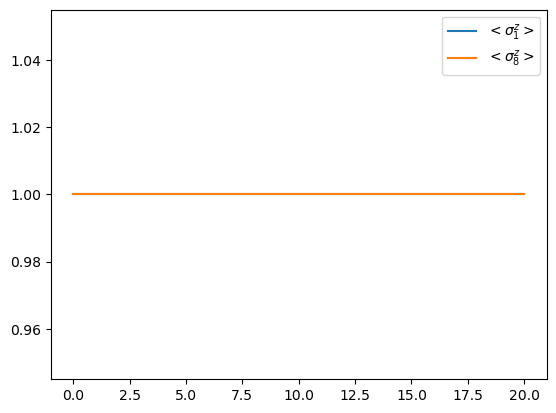

In [4]:
plt.figure()
plt.plot(times,result.expect[0]`,label='$<\sigma_1^z>$')
plt.plot(times,result.expect[1],label='$<\sigma_8^z>$')
plt.legend()

In [11]:
# Parameters
N = 30  # Dimension of Hilbert space
thetas = np.linspace(1, 360, 180)
alphas = 2 * np.exp(thetas / 180 * np.pi * 1j)
states = [displaced_ground_state(alpha, N) for alpha in alphas]
xvec = np.linspace(-5, 5, 500)  # Grid for plotting
pvec = np.linspace(-5, 5, 500)

# Set up the plot
def init_plot():
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_xlabel("$x$")
    ax.set_ylabel("$p$")
    theta = thetas[0]
    state = states[0]
    rho = state * state.dag()  # Density matrix
    W = wigner(rho, xvec, pvec)
    contour = ax.contourf(xvec, pvec, W, 100, cmap=wigner_cmap(W))
    cbar = fig.colorbar(contour, ax=ax)
    return fig, ax

def update(i):
    theta = thetas[i]
    state = states[i]
    rho = state * state.dag()  # Density matrix
    W = wigner(rho, xvec, pvec)
    
    ax.clear()
    cax = ax.contourf(xvec, pvec, W, 100, cmap=wigner_cmap(W))  # Placeholder cmap
    ax.set_title(f"$\\theta = {theta}^\\circ$")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$p$")


# Create the animation
fig, ax = init_plot()
anim = FuncAnimation(fig, update, frames=len(thetas), blit=False, interval=100)

# Display the animation
from IPython.display import HTML
HTML(anim.to_jshtml())

<IPython.core.display.Javascript object>

In [ ]:
anim.save('wigner_animation.mp4', writer='ffmpeg', fps=30)